In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm

from shamans.utils import eval_utils as eval

In [3]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False)
    return combined_csv

In [4]:
# load data
exp_id = 1
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])

print(exp_df['loc_algo'].unique())

['alp' 'mus' 'srp']


In [5]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)



In [6]:
# n_sources_choice = [1]
# source_type_choices = ['speech']
# snr_choices = np.arange(-30, 31, 10).tolist()
# noise_type_choices = ['awgn', 'alpha-1.2', 'alpha-0.8']
# sound_duration_choices = [0.5]
# add_reverb_choices = [False]

print(exp_df['sv_model'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())

['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
['awgn' 'alpha-0.8']
[1]
[-15 -12  -9  -6  -3   0   3   6   9  12  15  18  21]
[0.1 1. ]
[0.    0.123 0.273]
['alpha-1.2_beta-2_eps-1E-3_iter-500' 'alpha-1.2_beta-1_eps-1E-3_iter-500'
 'alpha-1.2_beta-0_eps-1E-3_iter-500' 'music_s-1' 'srp_phat']


## which seed is better for GP?

In [7]:
exp_df[
    exp_df['sv_model'].isin(['gp-steerer_8', 'gp-steerer_16', 'gp-steerer_32', 'gp-steerer_64', 'gp-steerer_128'])
].pivot_table(
    index=['seed'], 
    columns=['nObs'],
    values='ang_error', 
    aggfunc=['mean', 'std']
).style.format("{:.2f}").background_gradient(cmap='viridis', axis=0)

In [8]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666   
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

# SNR vs METHOD per RT60

['awgn' 'alpha-0.8']
noise_type: awgn, duration: 1, rt60: 0.0


<Figure size 1000x500 with 0 Axes>

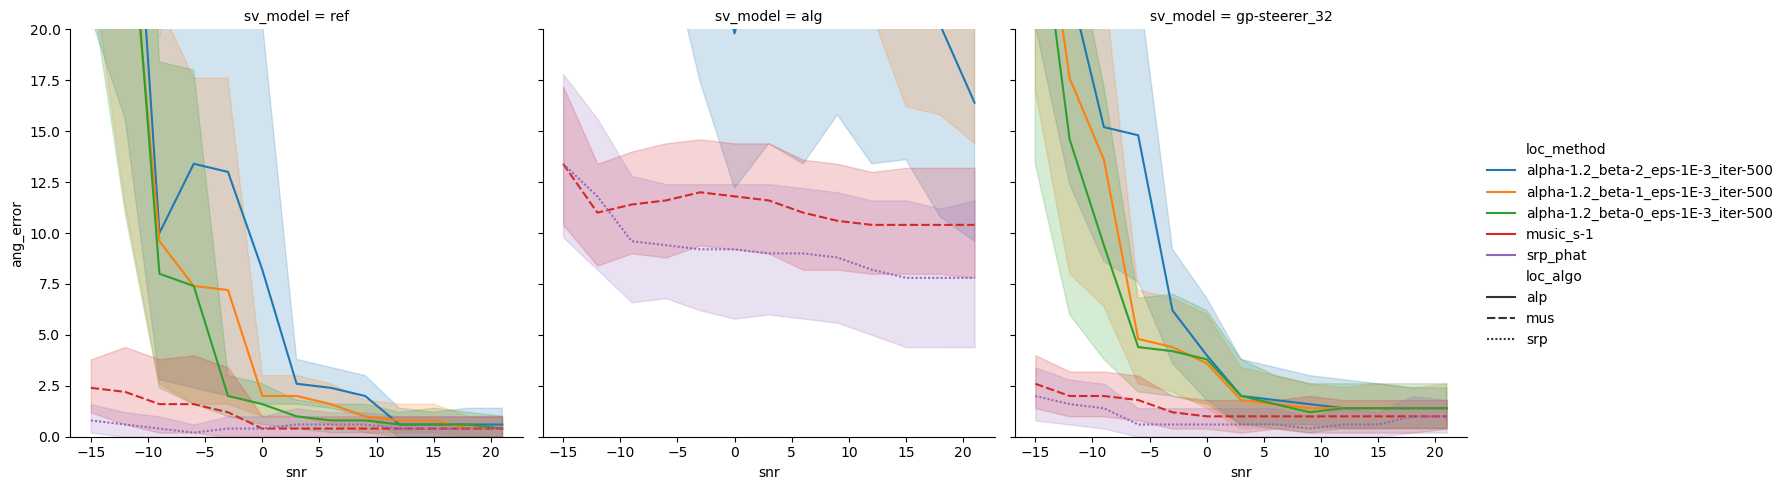

noise_type: awgn, duration: 1, rt60: 0.123


<Figure size 1000x500 with 0 Axes>

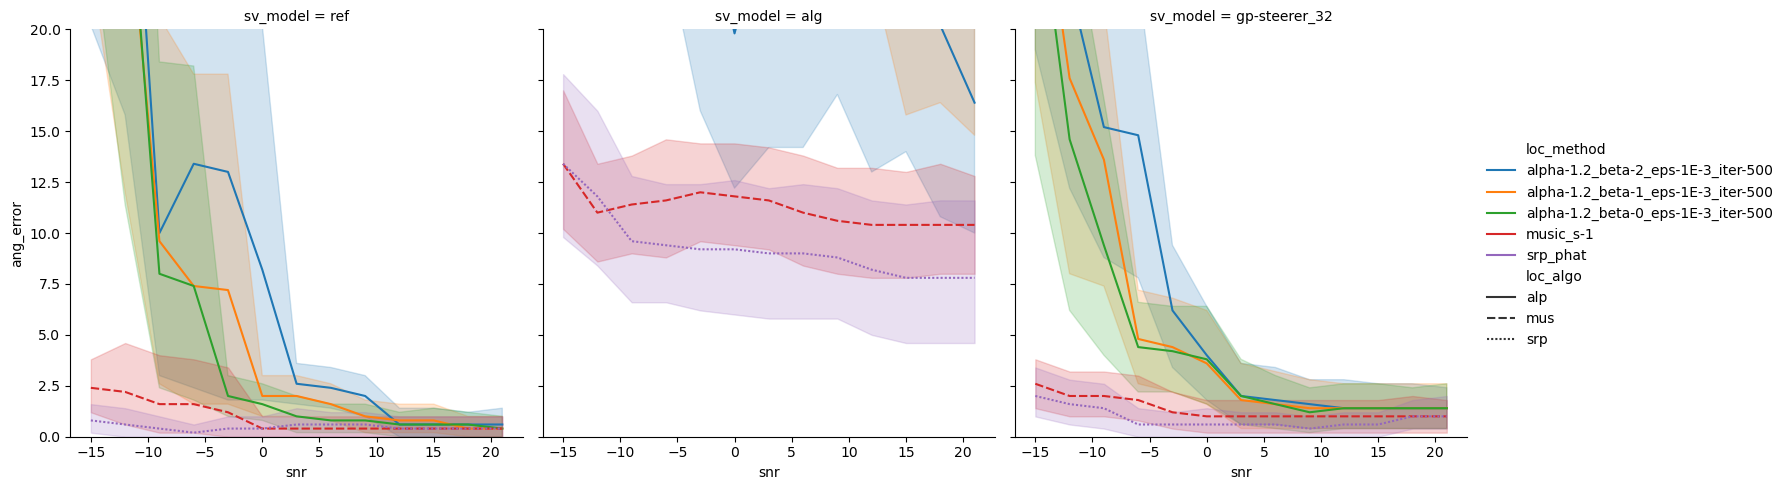

noise_type: awgn, duration: 1, rt60: 0.273


<Figure size 1000x500 with 0 Axes>

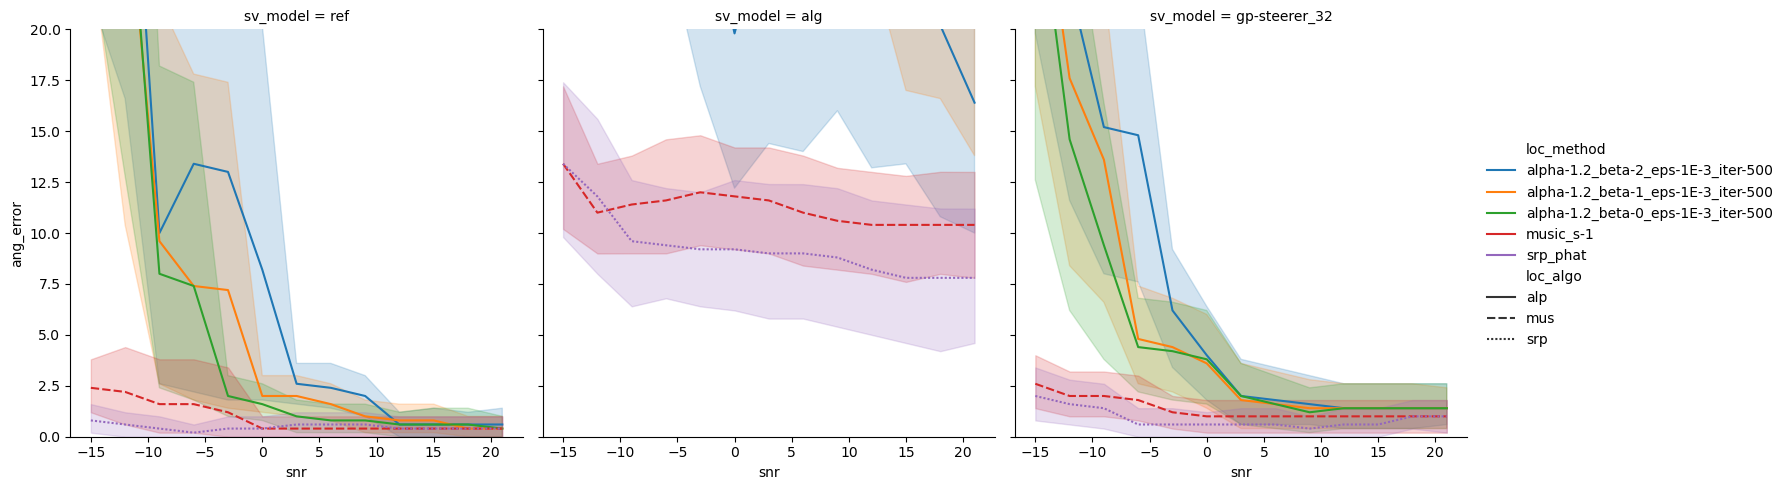

noise_type: alpha-0.8, duration: 1, rt60: 0.0


<Figure size 1000x500 with 0 Axes>

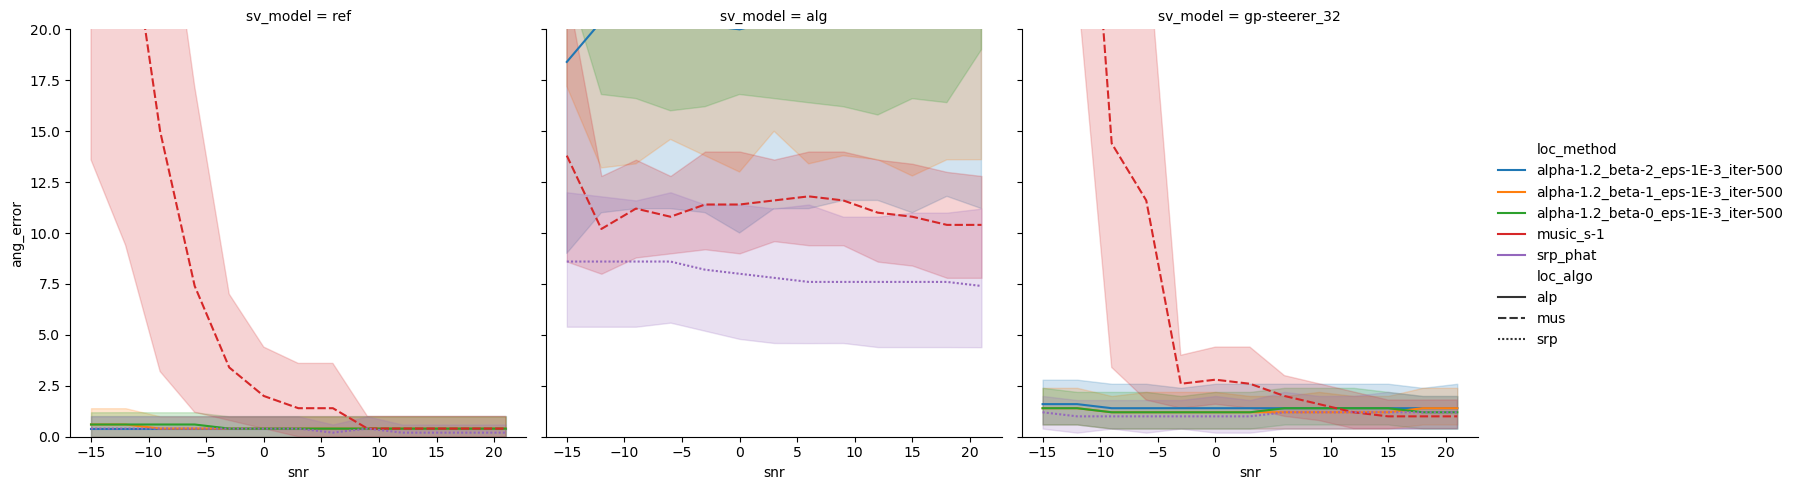

noise_type: alpha-0.8, duration: 1, rt60: 0.123


<Figure size 1000x500 with 0 Axes>

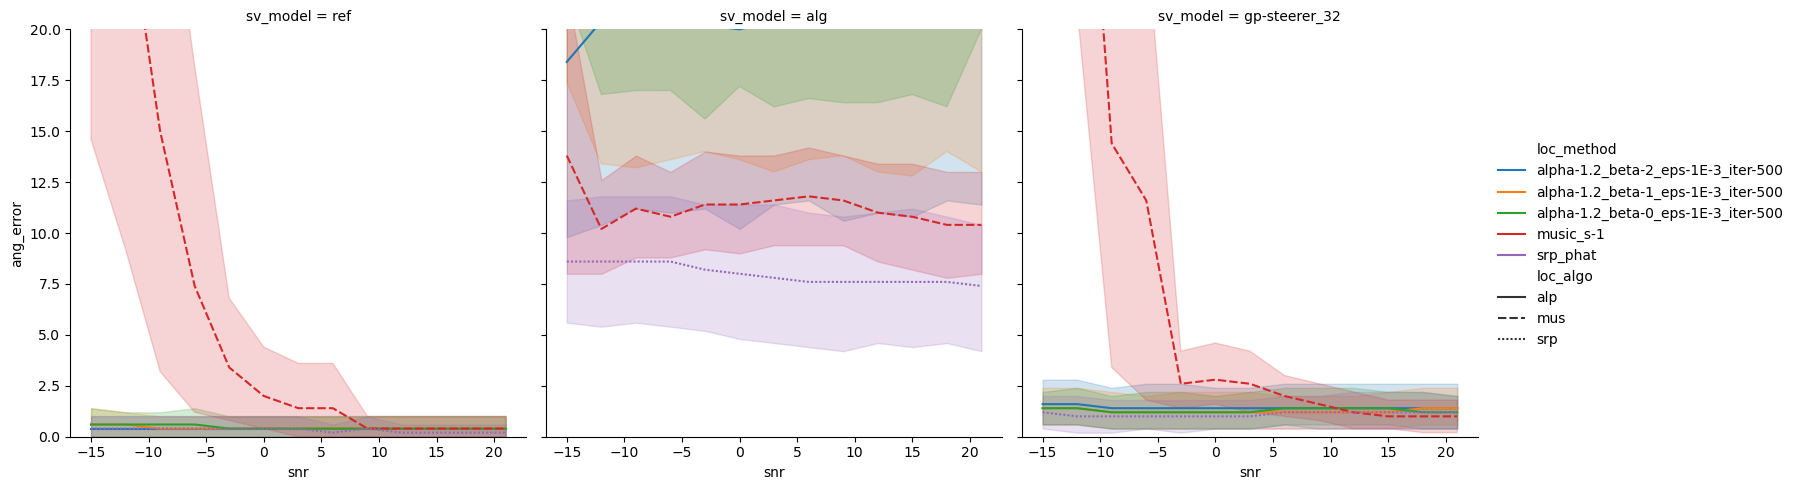

noise_type: alpha-0.8, duration: 1, rt60: 0.273


<Figure size 1000x500 with 0 Axes>

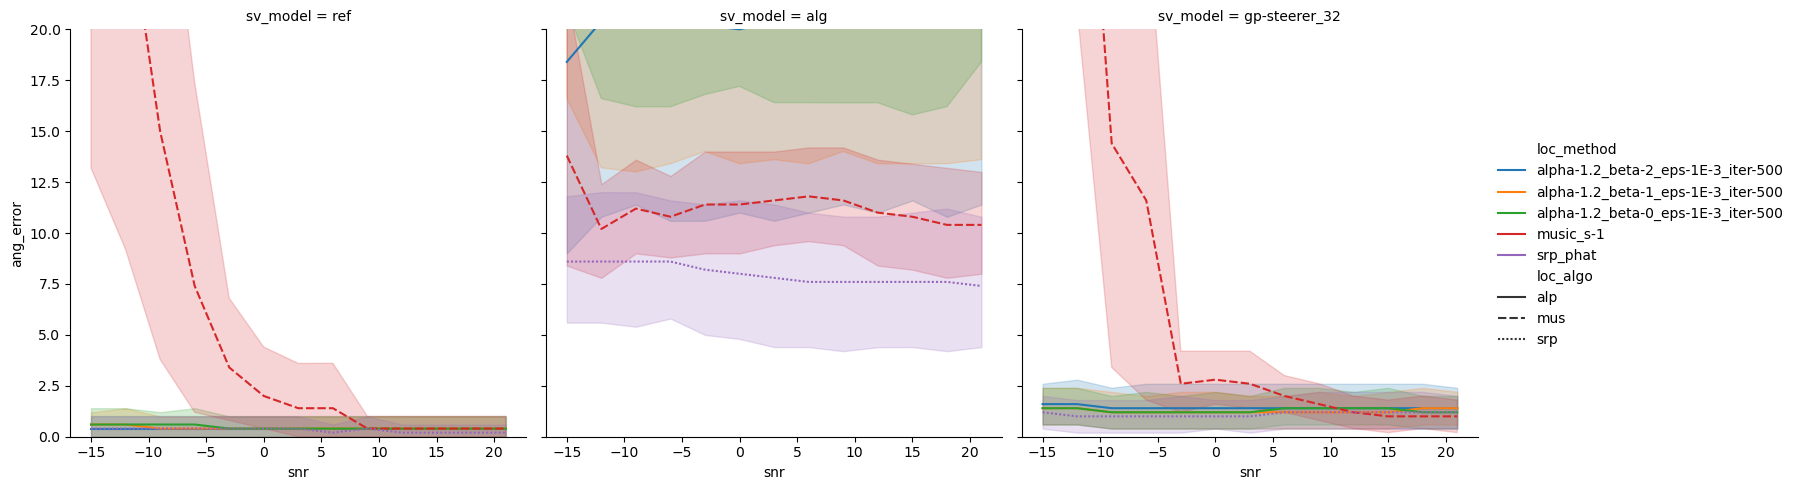

In [9]:
noise_types = exp_df['noise_type'].unique()
print(noise_types)

for duration in [1]:
    for noise_type in noise_types:
        for rt60 in exp_df['rt60'].unique():
        
            print(f"noise_type: {noise_type}, duration: {duration}, rt60: {rt60}")
        
            df_ = exp_df[
                (exp_df['noise_type'] == noise_type)
                & (exp_df['snr'] >= -20)
                & (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_32']))
                & (exp_df['seed'] == best_seed)
                & (exp_df['rt60'] > -1)
                & (exp_df['duration'] == duration)
            ]

            plt.figure(figsize=(10, 5))
            ax = sns.relplot(
                x='snr', y='ang_error', hue='loc_method', 
                style='loc_algo',
                data=df_, kind='line', col='sv_model',)
            ax.set(ylim=(0, 20))
            plt.show()